# Occupancy Detection - Kitchen

The aim of this notebook is to explain the power of automated feature engineering with a relational learning approach on multivariate time series data. Therefore different approaches for creating features are chosen and compared regarding their performance.

Summary:

- Prediction type: __Binary classification__
- Domain: __Energy__
- Prediction target: __Room occupancy__ 
- Source data: __1 tables, 19k rows__
- Population size: __19k__

_Author: Julian Oestreich_

The goal of this work is straight forward. Based on sensordata we want to predict wether the room is vacant or not.

The dataset we are using during this analysis was collected in the public kitchen area of a shared flat inhabited by 7 Students. The data was collected with a Raspberry Pi using different sensors just inside the cooking area of that room:
- **Variables**:
    * Date, year-month-day hour:minute:second
    * Temperature, in Celsius
    * Relative Humidity, %
    * Light, in Lux
    * Motion_Count, Integer
    * Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status
- **Size**: 19350 Rows
- **Resolution**: ~1min

# 1. Tracking Memory Consumption

A major issue of automated feature engineering is memory consumption. We would therefore like to be able to measure the memory consumption of different algorithms.

We will do so by tracking the overall system memory usage and then substracting the peak system memory usage from the initial memory usage. This gives a good approximation as long as we do not start any other memory-heavy processes while training.

In [1]:
import threading
import psutil
import time

In [2]:
class MemoryTracker():
    """
    The MemoryTracker measures the system's memory consumption
    once every second. It can be used to get an approximation of 
    the overall memory consumption of certain algorithms.
    """
    
    def __init__(self):
        self._initial_usage = 0
        self._max_usage = 0
        
        self._stop = False
        
        self.lock = threading.Lock()
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
    def __del__(self):
        self.stop()
        
    def _get_memory_usage(self):
        return psutil.virtual_memory().used

    def _measure_memory_usage(self):
        while True:
            time.sleep(1)
            
            self.lock.acquire()
                                    
            if self._stop:
                self.lock.release()
                break
            
            current_usage = self._get_memory_usage()
            
            if current_usage > self._max_usage:
                self._max_usage = current_usage
            
            self.lock.release()

    @property
    def peak_consumption(self):
        """
        The peak system memory consumption, in GB
        """
        self.lock.acquire()
        
        p_con = self._max_usage - self._initial_usage
        
        self.lock.release()
        
        p_con /= 1e9
        
        return p_con
    
    def start(self):
        """
        Starts measuring the memory consumption.
        """
        self.lock.acquire()
        
        self._initial_usage = self._get_memory_usage()
        
        self._max_usage = self._initial_usage
        
        self._stop = False
        
        self.th = threading.Thread(
            target=self._measure_memory_usage,
        )
        
        self.th.start()
        
        self.lock.release()
        
    def stop(self):
        """
        Stops measuring the memory consumption.
        """
        self.lock.acquire()
        self._stop = True
        self.lock.release()

In [3]:
memory_tracker = MemoryTracker()

# 1. Inspect the Data

Let's start our analysis by taking a closer look at our data. 

The first step is importing the relevant libraries and loading our CSV-Data into a Pandas Dataframe, which we can inspect then. 

In [4]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn')
%matplotlib inline 

# import the dataset
df = pd.read_csv("kitchen_19.11.20.csv")

# we also delete the motion_count variable from our dataset because it
# has only use as a target for regression
df = df.drop('motion_count', axis=1)

# print the datatypes
print(df.dtypes)

# print the dataframe
df

timestamp       object
light          float64
humidity       float64
temperature    float64
co2              int64
occupancy         bool
dtype: object


,timestamp,light,humidity,temperature,co2,occupancy
0,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,False
1,2020-11-05 18:47:57.153393,0.000000,49.900002,22.100000,486,False
2,2020-11-05 18:48:58.566046,0.000000,49.900002,22.100000,484,False
3,2020-11-05 18:49:59.993282,0.000000,49.900002,22.100000,484,False
4,2020-11-05 18:51:01.430247,0.000000,49.900002,22.100000,483,False
...,...,...,...,...,...,...
19374,2020-11-19 20:05:35.017684,1.666667,51.400002,22.299999,529,False
19375,2020-11-19 20:06:36.462629,1.666667,51.299999,22.200001,529,False
19376,2020-11-19 20:07:45.465099,1.666667,51.500000,22.299999,520,False
19377,2020-11-19 20:08:49.406900,1.666667,51.299999,22.299999,519,True


In [5]:
df.describe()

,light,humidity,temperature,co2
count,19379.000000,19379.000000,19379.000000,19379.000000
mean,14.339276,54.144156,21.421374,565.985500
std,29.535979,4.407887,0.816203,158.367536
min,0.000000,44.799999,20.000000,400.000000
25%,0.000000,51.500000,20.799999,416.000000
50%,1.666667,53.799999,21.299999,537.000000
75%,6.666667,56.200001,21.900000,685.000000
max,103.333333,93.000000,24.299999,1287.000000


By inspecting the datatypes we can tell that we do not only have numerical datatypes here. The occupancy column consists of boolean values, which are not very handy when it comes to plotting our data in the next steps. Therefore we're going to convert them into an int64 datatype.

In [6]:
df[["occupancy"]] = df[["occupancy"]].astype(int)
df.dtypes

timestamp       object
light          float64
humidity       float64
temperature    float64
co2              int64
occupancy        int64
dtype: object

We also have to convert our timestamps into a datetime format, which is recognizable by matplotlib.

In [7]:
def dateOrNotToDate(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')

In [8]:
def convert_dates(df):
    for i, date in enumerate(df['timestamp']):
        df.iloc[i, df.columns.get_loc('timestamp')] = dateOrNotToDate(date)

In [9]:
convert_dates(df)

### 1.1 Data Visualization

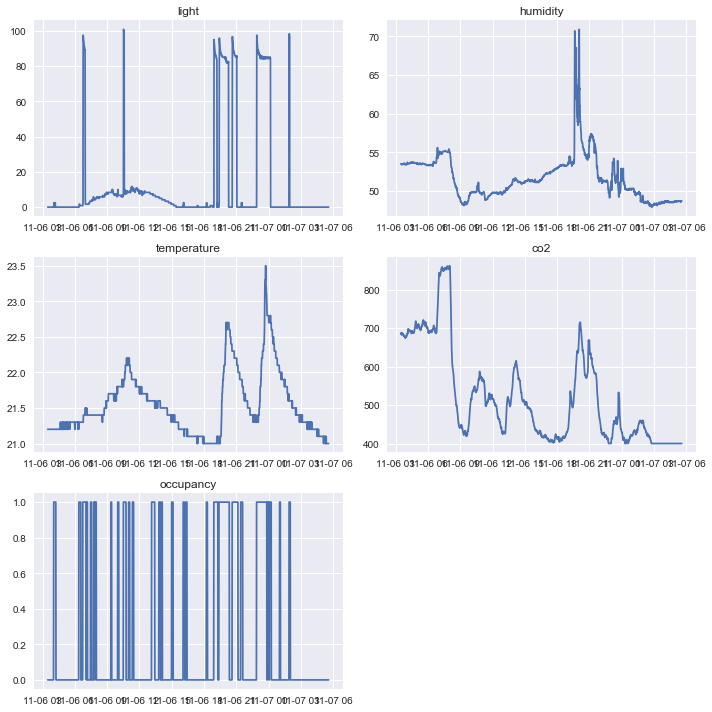

In [10]:
for i, col in enumerate(df.columns.values[1:7]):
    plt.subplot(3, 2, i+1)
    plt.plot(df['timestamp'][500:2000].values.tolist(), df[col][500:2000].values.tolist(), label=col)
    plt.title(col)
    fig, ax = plt.gcf(), plt.gca()
    ax.xaxis_date()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
    plt.grid(True)
plt.show()

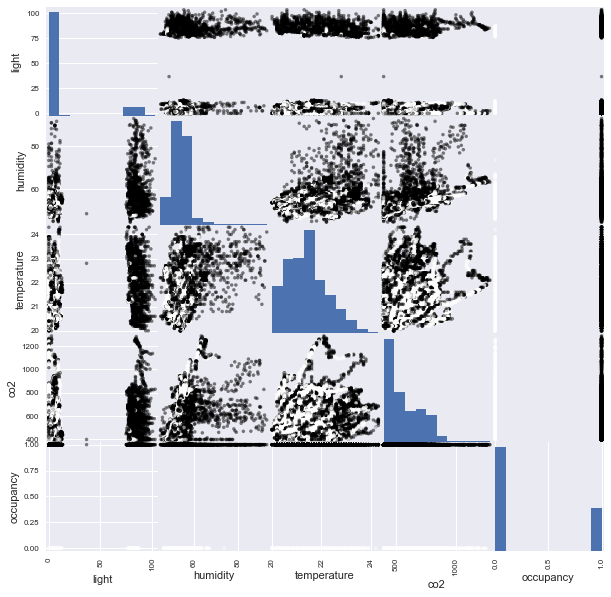

In [11]:
pd.plotting.scatter_matrix(df, c=df['occupancy'], figsize=[10, 10])
plt.show()

# 2. Analysing using manual Feature Engineering and sklearn

Now we want to make predictions on the occupancy level of the room by using manual engineered features on a simple Logisitc Regression.

Note that so far our dataset being a time series would have no effect so far on our model. By using only combinations of the available sensordata columns as our model features, the resulting model would treat all tuple values as if they were not in relation with their past values.

By taking a look at the scatter plot we can clearly tell that light is import for our model. Therefore we create a list of all possible feature combinations with the light feature and extend every list of feature combinations with their lagged values over the last hour.

After testing the fitted models on our testing data we print the 

- confusion matrix, 
- classification report
- the ROC Curve
- and the calculated AUC Value

for every model trained by given features.

## 2.1 Prepare the data

First we're creating copys of our dataframe for every Feature Engineering Option we are going to use.

In [12]:
df_sklearn = df.copy()
df_tsfresh = df.copy()
df_getml = df.copy()
df_featuretools = df.copy()

The first step of manual feature engineering is the creation of intuitive feature in the form of lag values.

In [13]:
df_sklearn['humidity_lag_1'] = df_sklearn['humidity'].shift(1)
df_sklearn['humidity_lag_5'] = df_sklearn['humidity'].shift(5)
df_sklearn['humidity_lag_10'] = df_sklearn['humidity'].shift(10)
df_sklearn['humidity_lag_30'] = df_sklearn['humidity'].shift(30)
df_sklearn['humidity_lag_45'] = df_sklearn['humidity'].shift(45)
df_sklearn['humidity_lag_60'] = df_sklearn['humidity'].shift(60)

df_sklearn['temperature_lag_1'] = df_sklearn['temperature'].shift(1)
df_sklearn['temperature_lag_5'] = df_sklearn['temperature'].shift(5)
df_sklearn['temperature_lag_10'] = df_sklearn['temperature'].shift(10)
df_sklearn['temperature_lag_30'] = df_sklearn['temperature'].shift(30)
df_sklearn['temperature_lag_45'] = df_sklearn['temperature'].shift(45)
df_sklearn['temperature_lag_60'] = df_sklearn['temperature'].shift(60)

df_sklearn['light_lag_1'] = df_sklearn['light'].shift(1)
df_sklearn['light_lag_5'] = df_sklearn['light'].shift(5)
df_sklearn['light_lag_10'] = df_sklearn['light'].shift(10)
df_sklearn['light_lag_30'] = df_sklearn['light'].shift(30)
df_sklearn['light_lag_45'] = df_sklearn['light'].shift(45)
df_sklearn['light_lag_60'] = df_sklearn['light'].shift(60)

df_sklearn['co2_lag_1'] = df_sklearn['co2'].shift(1)
df_sklearn['co2_lag_5'] = df_sklearn['co2'].shift(5)
df_sklearn['co2_lag_10'] = df_sklearn['co2'].shift(10)
df_sklearn['co2_lag_30'] = df_sklearn['co2'].shift(30)
df_sklearn['co2_lag_45'] = df_sklearn['co2'].shift(45)
df_sklearn['co2_lag_60'] = df_sklearn['co2'].shift(60)

df_sklearn = df_sklearn.dropna()  

df_sklearn

,timestamp,light,humidity,temperature,co2,occupancy,humidity_lag_1,humidity_lag_5,humidity_lag_10,humidity_lag_30,...,light_lag_10,light_lag_30,light_lag_45,light_lag_60,co2_lag_1,co2_lag_5,co2_lag_10,co2_lag_30,co2_lag_45,co2_lag_60
60,2020-11-05 19:49:54.408422,90.000000,52.700001,22.200001,573,1,51.299999,51.400002,50.599998,49.799999,...,2.500000,0.000000,0.000000,0.000000,570.0,530.0,516.0,473.0,479.0,486.0
61,2020-11-05 19:50:55.789441,0.000000,51.400002,22.299999,581,1,52.700001,51.700001,50.700001,49.900002,...,95.833333,0.000000,0.000000,0.000000,573.0,539.0,511.0,471.0,481.0,486.0
62,2020-11-05 19:51:57.233094,0.000000,51.400002,22.299999,594,1,51.400002,51.599998,50.900002,49.900002,...,94.166667,100.833333,0.000000,0.000000,581.0,549.0,515.0,470.0,481.0,484.0
63,2020-11-05 19:52:58.648391,0.000000,51.500000,22.299999,599,1,51.400002,51.299999,51.500000,49.799999,...,92.500000,97.500000,0.000000,0.000000,594.0,561.0,519.0,471.0,480.0,484.0
64,2020-11-05 19:54:00.189323,0.000000,51.200001,22.200001,606,1,51.500000,51.299999,51.299999,49.900002,...,91.666667,95.833333,0.000000,0.000000,599.0,570.0,522.0,472.0,484.0,483.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19374,2020-11-19 20:05:35.017684,1.666667,51.400002,22.299999,529,0,51.599998,51.700001,51.799999,50.599998,...,1.666667,1.666667,2.500000,78.333333,529.0,529.0,530.0,524.0,504.0,469.0
19375,2020-11-19 20:06:36.462629,1.666667,51.299999,22.200001,529,0,51.400002,51.599998,51.799999,50.900002,...,1.666667,1.666667,1.666667,78.333333,529.0,528.0,527.0,518.0,501.0,468.0
19376,2020-11-19 20:07:45.465099,1.666667,51.500000,22.299999,520,0,51.299999,51.599998,51.700001,51.000000,...,1.666667,0.000000,85.833333,78.333333,529.0,525.0,523.0,508.0,504.0,479.0
19377,2020-11-19 20:08:49.406900,1.666667,51.299999,22.299999,519,1,51.500000,51.400002,51.799999,51.000000,...,1.666667,0.000000,84.166667,78.333333,520.0,525.0,525.0,505.0,503.0,479.0


Then we perform our our training and testing set split by a ratio of 70:30 and also separate the target from the feautures.

In [14]:
sklearn_train = df_sklearn[:int(len(df_sklearn)*0.7)]
sklearn_test = df_sklearn[int(len(df_sklearn)*0.7):]

X_train = sklearn_train.drop('occupancy', axis=1)
y_train = sklearn_train['occupancy']

X_test = sklearn_test.drop('occupancy', axis=1)
y_test = sklearn_test['occupancy']

X_train

,timestamp,light,humidity,temperature,co2,humidity_lag_1,humidity_lag_5,humidity_lag_10,humidity_lag_30,humidity_lag_45,...,light_lag_10,light_lag_30,light_lag_45,light_lag_60,co2_lag_1,co2_lag_5,co2_lag_10,co2_lag_30,co2_lag_45,co2_lag_60
60,2020-11-05 19:49:54.408422,90.000000,52.700001,22.200001,573,51.299999,51.400002,50.599998,49.799999,49.900002,...,2.500000,0.000000,0.000000,0.000000,570.0,530.0,516.0,473.0,479.0,486.0
61,2020-11-05 19:50:55.789441,0.000000,51.400002,22.299999,581,52.700001,51.700001,50.700001,49.900002,49.900002,...,95.833333,0.000000,0.000000,0.000000,573.0,539.0,511.0,471.0,481.0,486.0
62,2020-11-05 19:51:57.233094,0.000000,51.400002,22.299999,594,51.400002,51.599998,50.900002,49.900002,49.900002,...,94.166667,100.833333,0.000000,0.000000,581.0,549.0,515.0,470.0,481.0,484.0
63,2020-11-05 19:52:58.648391,0.000000,51.500000,22.299999,599,51.400002,51.299999,51.500000,49.799999,50.000000,...,92.500000,97.500000,0.000000,0.000000,594.0,561.0,519.0,471.0,480.0,484.0
64,2020-11-05 19:54:00.189323,0.000000,51.200001,22.200001,606,51.500000,51.299999,51.299999,49.900002,50.000000,...,91.666667,95.833333,0.000000,0.000000,599.0,570.0,522.0,472.0,484.0,483.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13578,2020-11-15 15:05:00.415151,0.833333,58.500000,22.900000,739,58.500000,58.500000,58.299999,60.299999,58.000000,...,1.666667,85.833333,3.333333,4.166667,736.0,727.0,737.0,763.0,744.0,753.0
13579,2020-11-15 15:06:06.877966,0.833333,58.599998,22.900000,744,58.500000,58.500000,58.400002,60.000000,58.000000,...,2.500000,85.000000,3.333333,3.333333,739.0,727.0,738.0,783.0,738.0,752.0
13580,2020-11-15 15:07:10.843451,0.833333,58.599998,22.900000,744,58.599998,58.599998,58.400002,59.500000,59.000000,...,2.500000,85.000000,3.333333,3.333333,744.0,732.0,732.0,790.0,736.0,754.0
13581,2020-11-15 15:08:12.233832,0.833333,58.599998,22.900000,746,58.599998,58.500000,58.400002,59.200001,58.700001,...,2.500000,2.500000,3.333333,3.333333,744.0,733.0,724.0,795.0,731.0,759.0


We then create a powerset of all the original column combinations containing also the `light` column

In [15]:
features = ['humidity', 'temperature', 'co2']
features_combs_list = [x for length in range(len(features)+1) for x in itertools.combinations(features, length)][1:]
features_combs_list = [x + ('light',) for x in features_combs_list]
features_combs_list.append(('light',))
features_combs_list

[('humidity', 'light'),
 ('temperature', 'light'),
 ('co2', 'light'),
 ('humidity', 'temperature', 'light'),
 ('humidity', 'co2', 'light'),
 ('temperature', 'co2', 'light'),
 ('humidity', 'temperature', 'co2', 'light'),
 ('light',)]

This list of feature combinations is then extendes by the relevant and available *lagged values* of the last hour.

In [16]:
lagged_features_combs_list = []
for features in features_combs_list:
    new_features = features
    for feature in features:
        new_features = new_features + (feature + '_lag_1', 
                                       feature + '_lag_5',  
                                       feature + '_lag_10',
                                       feature + '_lag_30',
                                       feature + '_lag_45',
                                       feature + '_lag_60',)
        
    lagged_features_combs_list.append(new_features)
    
features_combs_list = lagged_features_combs_list + features_combs_list
len(features_combs_list)

16

## 2.2 Predictive Modelling and Evaluation

('humidity', 'light', 'humidity_lag_1', 'humidity_lag_5', 'humidity_lag_10', 'humidity_lag_30', 'humidity_lag_45', 'humidity_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3753  656]
 [ 189 1198]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4409
           1       0.65      0.86      0.74      1387

    accuracy                           0.85      5796
   macro avg       0.80      0.86      0.82      5796
weighted avg       0.88      0.85      0.86      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.870


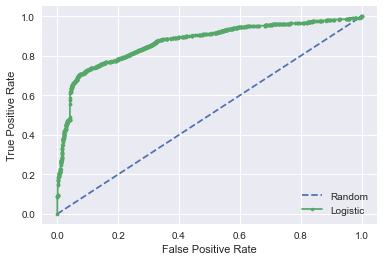

('temperature', 'light', 'temperature_lag_1', 'temperature_lag_5', 'temperature_lag_10', 'temperature_lag_30', 'temperature_lag_45', 'temperature_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3655  590]
 [ 287 1264]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      4245
           1       0.68      0.81      0.74      1551

    accuracy                           0.85      5796
   macro avg       0.80      0.84      0.82      5796
weighted avg       0.86      0.85      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.863


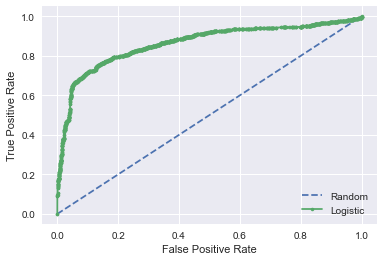

('co2', 'light', 'co2_lag_1', 'co2_lag_5', 'co2_lag_10', 'co2_lag_30', 'co2_lag_45', 'co2_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3736  657]
 [ 206 1197]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4393
           1       0.65      0.85      0.74      1403

    accuracy                           0.85      5796
   macro avg       0.80      0.85      0.82      5796
weighted avg       0.87      0.85      0.86      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.865


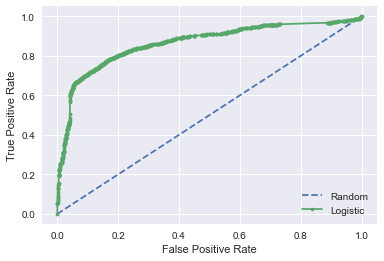

('humidity', 'temperature', 'light', 'humidity_lag_1', 'humidity_lag_5', 'humidity_lag_10', 'humidity_lag_30', 'humidity_lag_45', 'humidity_lag_60', 'temperature_lag_1', 'temperature_lag_5', 'temperature_lag_10', 'temperature_lag_30', 'temperature_lag_45', 'temperature_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3711  598]
 [ 231 1256]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4309
           1       0.68      0.84      0.75      1487

    accuracy                           0.86      5796
   macro avg       0.81      0.85      0.83      5796
weighted avg       0.87      0.86      0.86      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.860


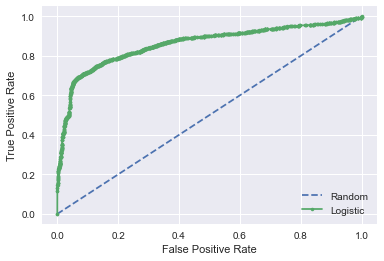

('humidity', 'co2', 'light', 'humidity_lag_1', 'humidity_lag_5', 'humidity_lag_10', 'humidity_lag_30', 'humidity_lag_45', 'humidity_lag_60', 'co2_lag_1', 'co2_lag_5', 'co2_lag_10', 'co2_lag_30', 'co2_lag_45', 'co2_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3746  662]
 [ 196 1192]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4408
           1       0.64      0.86      0.74      1388

    accuracy                           0.85      5796
   macro avg       0.80      0.85      0.82      5796
weighted avg       0.88      0.85      0.86      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.868


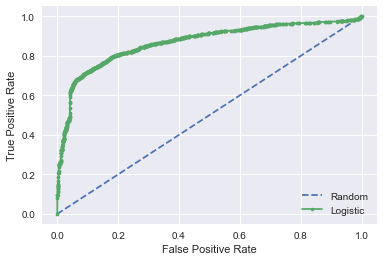

('temperature', 'co2', 'light', 'temperature_lag_1', 'temperature_lag_5', 'temperature_lag_10', 'temperature_lag_30', 'temperature_lag_45', 'temperature_lag_60', 'co2_lag_1', 'co2_lag_5', 'co2_lag_10', 'co2_lag_30', 'co2_lag_45', 'co2_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3702  644]
 [ 240 1210]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      4346
           1       0.65      0.83      0.73      1450

    accuracy                           0.85      5796
   macro avg       0.80      0.84      0.81      5796
weighted avg       0.87      0.85      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.857


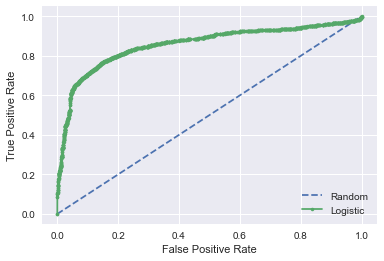

('humidity', 'temperature', 'co2', 'light', 'humidity_lag_1', 'humidity_lag_5', 'humidity_lag_10', 'humidity_lag_30', 'humidity_lag_45', 'humidity_lag_60', 'temperature_lag_1', 'temperature_lag_5', 'temperature_lag_10', 'temperature_lag_30', 'temperature_lag_45', 'temperature_lag_60', 'co2_lag_1', 'co2_lag_5', 'co2_lag_10', 'co2_lag_30', 'co2_lag_45', 'co2_lag_60', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3711  640]
 [ 231 1214]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      4351
           1       0.65      0.84      0.74      1445

    accuracy                           0.85      5796
   macro avg       0.80      0.85      0.82      5796
weighted avg       0.87      0.85      0.86      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.857


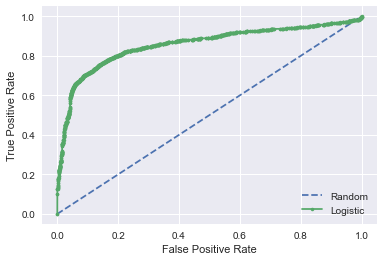

('light', 'light_lag_1', 'light_lag_5', 'light_lag_10', 'light_lag_30', 'light_lag_45', 'light_lag_60')
Confusion Matrix
[[3736  645]
 [ 206 1209]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4381
           1       0.65      0.85      0.74      1415

    accuracy                           0.85      5796
   macro avg       0.80      0.85      0.82      5796
weighted avg       0.88      0.85      0.86      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.882


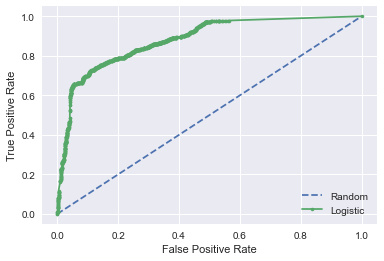

('humidity', 'light')
Confusion Matrix
[[3777  760]
 [ 165 1094]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4537
           1       0.59      0.87      0.70      1259

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.80      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.829


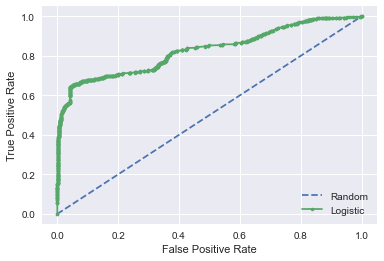

('temperature', 'light')
Confusion Matrix
[[3777  783]
 [ 165 1071]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4560
           1       0.58      0.87      0.69      1236

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.79      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.869


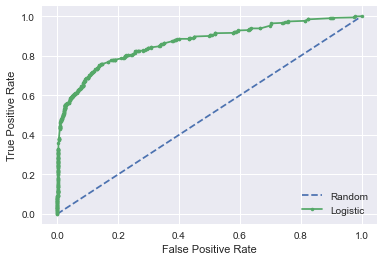

('co2', 'light')
Confusion Matrix
[[3777  784]
 [ 165 1070]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4561
           1       0.58      0.87      0.69      1235

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.79      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.835


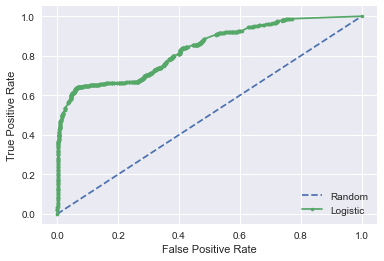

('humidity', 'temperature', 'light')
Confusion Matrix
[[3777  757]
 [ 165 1097]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4534
           1       0.59      0.87      0.70      1262

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.80      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.861


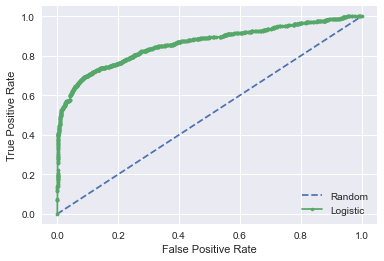

('humidity', 'co2', 'light')
Confusion Matrix
[[3777  764]
 [ 165 1090]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4541
           1       0.59      0.87      0.70      1255

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.80      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.828


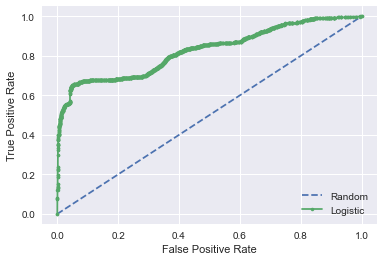

('temperature', 'co2', 'light')
Confusion Matrix
[[3777  784]
 [ 165 1070]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4561
           1       0.58      0.87      0.69      1235

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.79      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.863


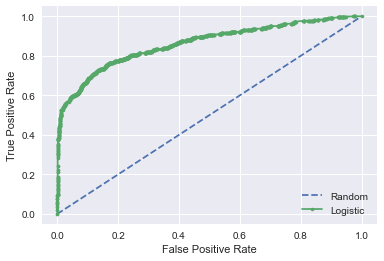

('humidity', 'temperature', 'co2', 'light')
Confusion Matrix
[[3777  784]
 [ 165 1070]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4561
           1       0.58      0.87      0.69      1235

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.79      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.809


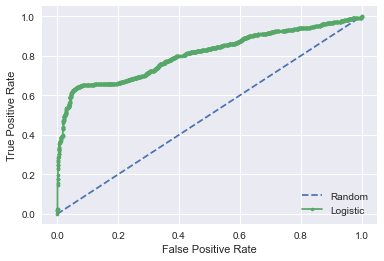

('light',)
Confusion Matrix
[[3777  784]
 [ 165 1070]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      4561
           1       0.58      0.87      0.69      1235

    accuracy                           0.84      5796
   macro avg       0.77      0.85      0.79      5796
weighted avg       0.88      0.84      0.85      5796

ROC Curve
Random: ROC AUC=0.500
Logistic: ROC AUC=0.858


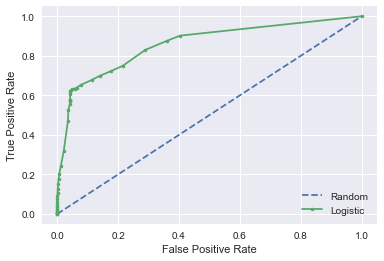

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

metrics = []

for i, features in enumerate(features_combs_list):
    print(features)
    print('===================================')
    X = X_train.loc[:, features]
    X_t = X_test.loc[:, features]
    
    ns_probs = [0 for _ in range(len(y_test))]
    model = LogisticRegression(max_iter=10000)
    model.fit(X, y_train)
    pred = model.predict(X_t)
    lr_probs = model.predict_proba(X_t)
    
    print("Confusion Matrix")
    print('===================================')
    print(confusion_matrix(pred, y_test))
    
    
    m = classification_report(pred, y_test, output_dict=True)
    print()
    print("Classification Report")
    print('===================================')
    print(classification_report(pred, y_test))
    
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    cross_entropy_test = log_loss(y_test, pred)
    #cross_entropy_train = log_loss(y_, pred)
    
    m['auc_trn'] = ns_auc
    m['auc_test'] = lr_auc
    m['features'] = features
    #m['cross_entropy_test'] = cross_entropy_test
    m['roc_test'] = roc_curve(y_test, lr_probs)
    metrics.append(m)
    #print("log_loss: ", cross_entropy)
    
    # summarize scores
    print("ROC Curve")
    print('===================================')
    print('Random: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    
    # axis labdels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # show the legend
    plt.legend(loc='lower right')
    # show the plot
    plt.show()


In [20]:
sorted_by_acc = sorted(metrics, key=lambda x: x['accuracy'], reverse=True)[0:5]
sorted_by_auc = sorted(metrics, key=lambda x: x['auc_test'], reverse=True)[0:5]

print("TOP FEATURES")
print("\n===========================================================\n")
print("The two top rated feature combos regarding accuracy are:")
for i, d in enumerate(sorted_by_acc):
    print(f"\n[{i+1}]")
    pprint(d['features'])
    print(f"accuracy: {round(d['accuracy'],5)}")
    print(f"Area under ROC Curve: {round(d['auc_test'],5)}")

print("\n===========================================================\n")
print("The two best rated feature combos regarding AUC are:")
for i,d in enumerate(sorted_by_auc):
    print(f"\n[{i+1}]")
    pprint(d['features'])
    print(f"accuracy: {round(d['accuracy'],5)}")
    print(f"Area under ROC Curve: {round(d['auc_test'],5)}")

TOP FEATURES


The two top rated feature combos regarding accuracy are:

[1]
('humidity',
 'temperature',
 'light',
 'humidity_lag_1',
 'humidity_lag_5',
 'humidity_lag_10',
 'humidity_lag_30',
 'humidity_lag_45',
 'humidity_lag_60',
 'temperature_lag_1',
 'temperature_lag_5',
 'temperature_lag_10',
 'temperature_lag_30',
 'temperature_lag_45',
 'temperature_lag_60',
 'light_lag_1',
 'light_lag_5',
 'light_lag_10',
 'light_lag_30',
 'light_lag_45',
 'light_lag_60')
accuracy: 0.85697
Area under ROC Curve: 0.8604

[2]
('humidity',
 'light',
 'humidity_lag_1',
 'humidity_lag_5',
 'humidity_lag_10',
 'humidity_lag_30',
 'humidity_lag_45',
 'humidity_lag_60',
 'light_lag_1',
 'light_lag_5',
 'light_lag_10',
 'light_lag_30',
 'light_lag_45',
 'light_lag_60')
accuracy: 0.85421
Area under ROC Curve: 0.87012

[3]
('light',
 'light_lag_1',
 'light_lag_5',
 'light_lag_10',
 'light_lag_30',
 'light_lag_45',
 'light_lag_60')
accuracy: 0.85317
Area under ROC Curve: 0.88162

[4]
('humidity',
 'co2',


# 3. Analysis using TSFresh Features

Lets start by importing the relevant libraries and split our dataset.

In [22]:
import time
import gc
import tsfresh
from scipy.stats import pearsonr
from datetime import datetime
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_selection.relevance import calculate_relevance_table

df_tsfresh['id'] = 1 
df_tsfresh['timestamp'] = df_tsfresh['timestamp'].astype(str)

tsfresh_train = df_tsfresh[:int(len(df_tsfresh)*0.7)]
tsfresh_test = df_tsfresh[int(len(df_tsfresh)*0.7):]

## 3.1 Extract Features

In this step i will be selecting and extracting relevant features by using the open source software TSFresh within a comfortably usable Wrapper class provided by my thesis mentor Dr. Patrick Urbanke.

I am allowing tsfresh to look back also 60 Minutes in time to add 20 relevant features to the datasets.

In [23]:
class TSFreshBuilder():
    
    def __init__(self, num_features, memory, column_id, time_stamp, target):
        """
        Scikit-learn style feature builder based on TSFresh.
        
        Args:
            
            num_features: The (maximum) number of features to build.
            
            memory: How much back in time you want to go until the
                    feature builder starts "forgetting" data.
                    
            column_id: The name of the column containing the ids.
            
            time_stamp: The name of the column containing the time stamps.
            
            target: The name of the target column.
        """
        self.num_features = num_features
        self.memory = memory
        self.column_id = column_id
        self.time_stamp = time_stamp
        self.target = target
        
        self.selected_features = []
        
    def _add_original_columns(self, original_df, df_selected):
        for colname in original_df.columns:
            df_selected[colname] = np.asarray(
                original_df[colname])
                    
        return df_selected

    def _extract_features(self, df):
        df_rolled = roll_time_series(
            df, 
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            max_timeshift=self.memory
        )
        
        extracted_minimal = tsfresh.extract_features(
            df_rolled,
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters()
        )
        
        extracted_index_based = tsfresh.extract_features(
            df_rolled,
            column_id=self.column_id, 
            column_sort=self.time_stamp,
            default_fc_parameters=tsfresh.feature_extraction.settings.IndexBasedFCParameters()
        )
        
        extracted_features = pd.concat(
            [extracted_minimal, extracted_index_based], axis=1
        )
        del extracted_minimal
        del extracted_index_based
        
        gc.collect()
        
        extracted_features[
            extracted_features != extracted_features] = 0.0  
        
        extracted_features[
            np.isinf(extracted_features)] = 0.0 
        
        return extracted_features
        
    def _print_time_taken(self, begin, end):

        seconds = end - begin

        hours = int(seconds / 3600)
        seconds -= float(hours * 3600)

        minutes = int(seconds / 60)
        seconds -= float(minutes * 60)

        seconds = round(seconds, 6)

        print(
            "Time taken: " + str(hours) + "h:" +
            str(minutes) + "m:" + str(seconds)
        )

        print("")
        
    def _remove_target_column(self, df):
        colnames = np.asarray(df.columns)
        
        if self.target not in colnames:
            return df
        
        colnames = colnames[colnames != self.target]
        
        return df[colnames]
        
    def _select_features(self, df, target):
        df_selected = tsfresh.select_features(
            df, 
            target
        )
        
        colnames = np.asarray(df_selected.columns)

        correlations = np.asarray([
            np.abs(pearsonr(target, df_selected[col]))[0] for col in colnames
        ])
        
        # [::-1] is somewhat unintuitive syntax,
        # but it reverses the entire column.
        self.selected_features = colnames[
            np.argsort(correlations)
        ][::-1][:self.num_features]

        return df_selected[self.selected_features]
        
    def fit(self, df):
        """
        Fits the features.
        """
        begin = time.time()

        target = np.asarray(df[self.target])
        
        df_without_target = self._remove_target_column(df)
        
        df_extracted = self._extract_features(
            df_without_target)
        
        df_selected = self._select_features(
            df_extracted, target)
                
        del df_extracted
        gc.collect()
        
        df_selected = self._add_original_columns(df, df_selected)

        end = time.time()
        
        self._print_time_taken(begin, end)
        
        return df_selected
    
    def transform(self, df):
        """
        Transforms the raw data into a set of features.
        """
        df_extracted = self._extract_features(df)
        
        df_selected = df_extracted[self.selected_features]
        
        del df_extracted
        gc.collect()
        
        df_selected = self._add_original_columns(df, df_selected)
                                         
        return df_selected

In [24]:
tsfresh_builder = TSFreshBuilder(
    num_features=20,
    memory=60,
    column_id="id",
    time_stamp="timestamp",
    target="occupancy"
)

In [25]:
start = time.time()
memory_tracker.start()
tsfresh_train_pandas = tsfresh_builder.fit(tsfresh_train)
tsfresh_test_pandas = tsfresh_builder.transform(tsfresh_test)
memory_tracker.stop()
end = time.time()

print("Elapsed Time:")
print(end-start)

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

Feature Extraction: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Time taken: 0h:1m:16.690169



Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Elapsed Time:
116.884446144104
Memory consumption: 
0.371929088


## 3.2 Predictive Modelling

Because TSFresh doesn't come with a predictor, we are using getML for our predicitons. First we're setting a project for the getML Engine, load our data and set the roles for our DataFrame Columns.

In [27]:
import getml
                        
getml.engine.set_project('occupancy_kitchen')

Creating new project 'occupancy_kitchen'


In [28]:
tsfresh_train = getml.data.DataFrame.from_pandas(tsfresh_train_pandas, "tsfresh_train")
tsfresh_test = getml.data.DataFrame.from_pandas(tsfresh_test_pandas, "tsfresh_test")

In [29]:
for df in [tsfresh_train, tsfresh_test]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role("timestamp", getml.data.roles.time_stamp, time_formats=['%Y-%m-%d %H:%M:%S.%F'])
    df.set_role(df.unused_float_names, getml.data.roles.numerical)
    df.set_role(["id"], getml.data.roles.unused_float)

In [30]:
predictor = getml.predictors.LogisticRegression()
seasonal = getml.preprocessors.Seasonal()

pipe_tsfresh = getml.pipeline.Pipeline(
    tags=['tsfresh'],
    predictors=[predictor],
    preprocessors=[seasonal]
)

In [31]:
pipe_tsfresh.fit(tsfresh_train)


Checking data model...
OK.

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.280129



Pipeline(preprocessors=['Seasonal'], feature_learners=[], feature_selectors=[], 
         include_categorical=False, peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['tsfresh'], 
         share_selected_features=0.5)

url: http://localhost:1709/getpipeline/FBKkwb/0/

## 3.3 Model Evaluation

In [32]:
in_sample = pipe_tsfresh.score(tsfresh_train)

out_of_sample = pipe_tsfresh.score(tsfresh_test)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)




Accuracy (training): 0.84497
AUC (training): 0.87413

Accuracy (testing): 0.84125
AUC (testing): 0.87246



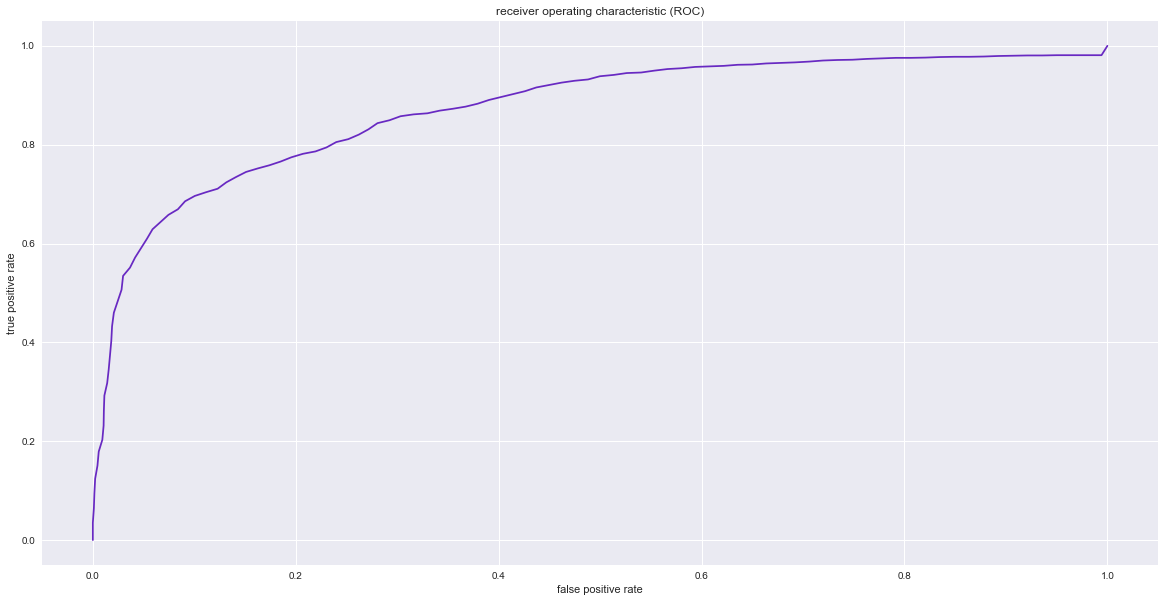

In [34]:
# Refers to the data from the last time
# we called .score(...).
fpr_ts, tpr_ts = pipe_tsfresh.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_ts, tpr_ts, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

## 3.4 Study Features

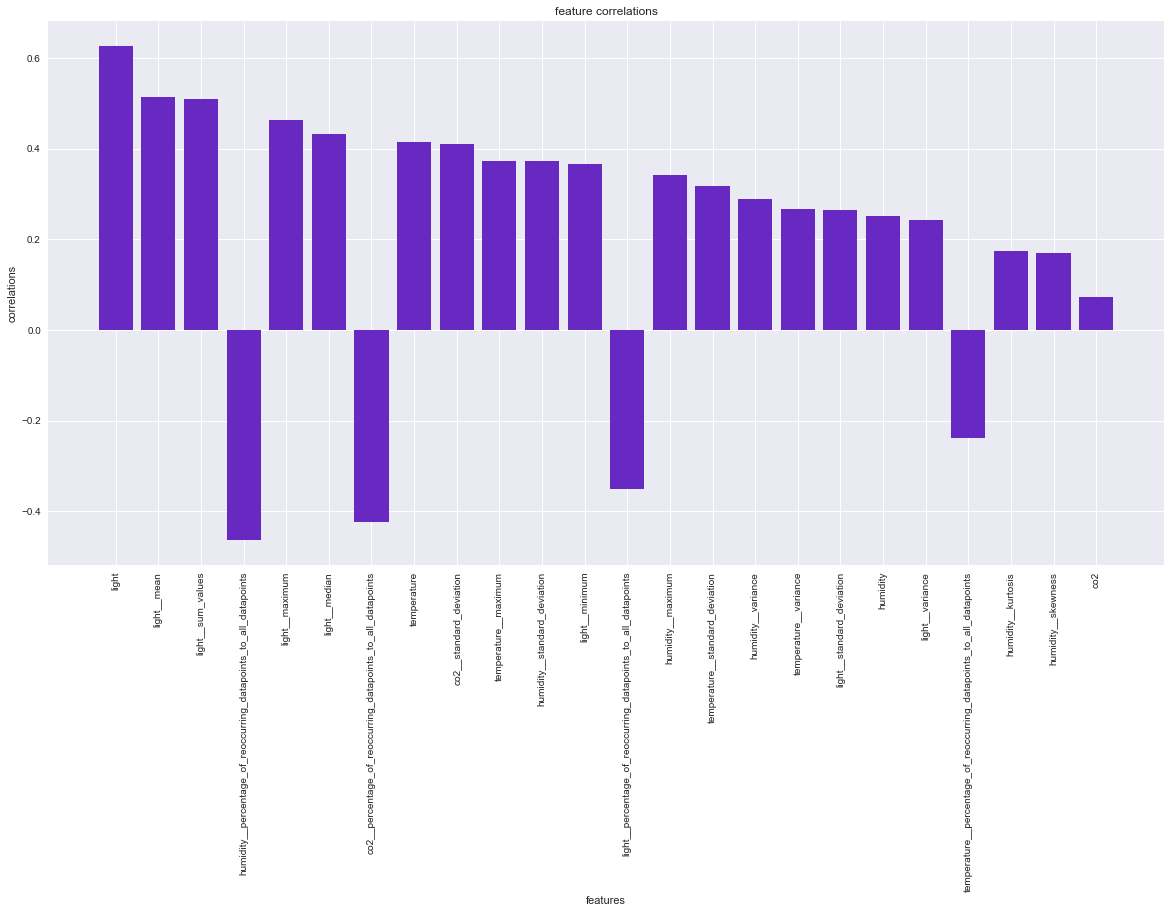

In [35]:
names, correlations = pipe_tsfresh.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

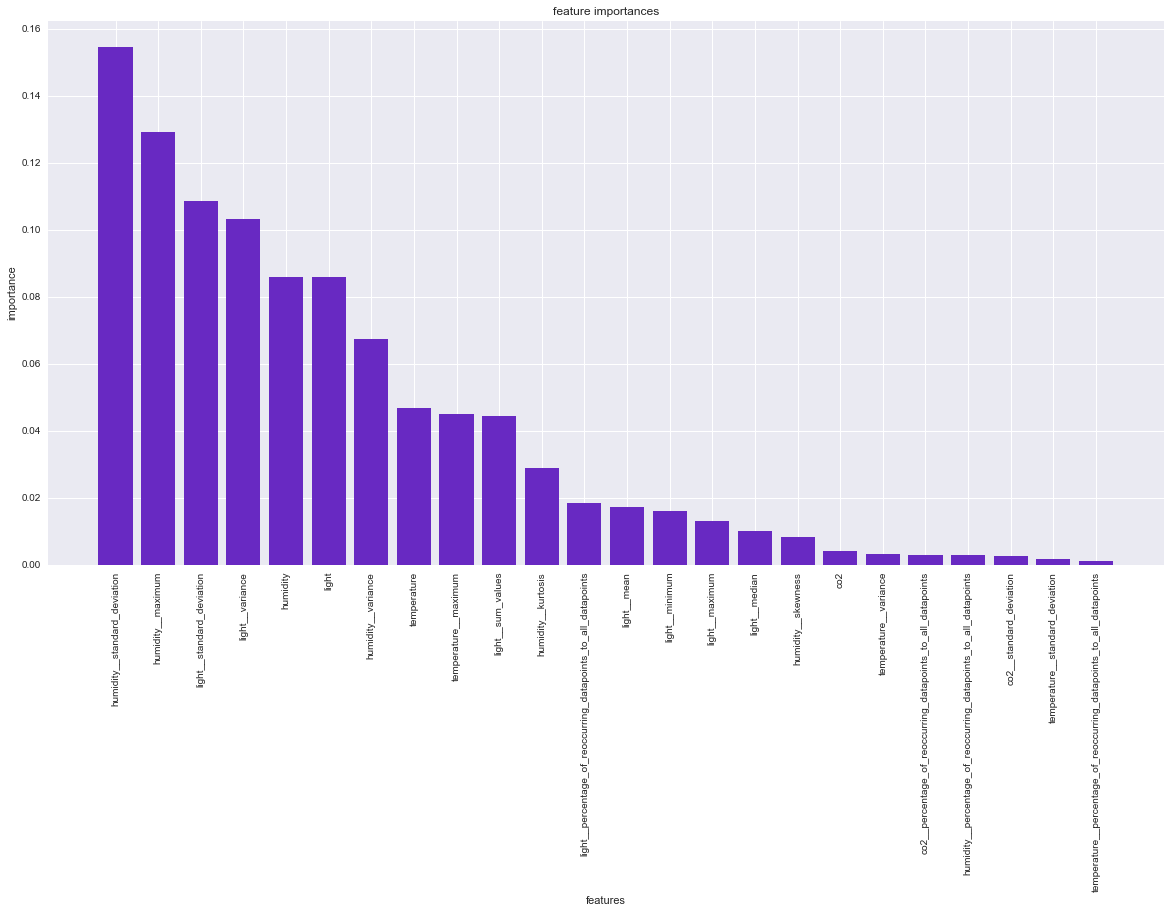

In [36]:
names, importances = pipe_tsfresh.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

# 3. Analysis using getML Features

## 3.1 Load the data

The first step of using getML for our analysis is to load our data into the getML Engine.

We also need to set the relevant roles for our DataFrame Columns.

In [37]:
getml_train = df_getml[:int(len(df_getml)*0.7)]
getml_test = df_getml[int(len(df_getml)*0.7):]

In [38]:
data_full = getml.data.DataFrame.from_pandas(df_getml, "data_full")
data_train = getml.data.DataFrame.from_pandas(getml_train, "data_train")
data_test = getml.data.DataFrame.from_pandas(getml_test, "data_test")

In [39]:
for df in [data_full, data_train, data_test]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(['temperature', 'humidity', 'light', 'co2'], getml.data.roles.numerical)
    df.set_role("timestamp", getml.data.roles.time_stamp, time_formats=['%Y-%m-%d %H:%M:%S.%F'])

In [40]:
data_full

Name,timestamp,occupancy,temperature,humidity,light,co2
Role,time_stamp,target,numerical,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,,
0,2020-11-05T18:46:48.192878Z,0,22.1,50,0,486
1,2020-11-05T18:47:57.153393Z,0,22.1,49.9,0,486
2,2020-11-05T18:48:58.566046Z,0,22.1,49.9,0,484
3,2020-11-05T18:49:59.993282Z,0,22.1,49.9,0,484
4,2020-11-05T18:51:01.430247Z,0,22.1,49.9,0,483
,...,...,...,...,...,...
19374,2020-11-19T20:05:35.017684Z,0,22.3,51.4,1.66667,529
19375,2020-11-19T20:06:36.462629Z,0,22.2,51.3,1.66667,529


## 3.2 getML Pipeline

We use a [MultirelModel](https://docs.getml.com/latest/api/getml.models.MultirelModel.html) and a [RelboostModel](https://docs.getml.com/latest/api/getml.feature_learning.RelboostModel.html) for generating the features, as well as a simple logistic regression for prediction.

We choose to consider data within the last 60 minutes for creating our features.

In [41]:
multirel = getml.feature_learning.MultirelTimeSeries(
    ts_name="timestamp",
    horizon=0.0,
    memory=getml.data.time.minutes(60),
    allow_lagged_targets=False,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_features=20
)

#relboost = getml.feature_learning.RelboostTimeSeries(
#    ts_name="timestamp",
#    horizon=0.0,
#    memory=getml.data.time.minutes(60),
#    allow_lagged_targets=False,
#    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
#    num_features=10
#)

predictor = getml.predictors.LogisticRegression()

In [42]:
seasonal = getml.preprocessors.Seasonal()
pipe = getml.pipeline.Pipeline(
    tags=['memory: 60min', 'horizon: 0'],
    feature_learners=[multirel],
    predictors=[predictor],
    preprocessors=[seasonal],
)

In [43]:
pipe.check(data_train)

Checking data model...
OK.


## 3.3 Model Training

In [44]:
memory_tracker.start()
start = time.time()
pipe.fit(data_train)
memory_tracker.stop()
end= time.time()

print("Elapsed Time: ", (end-start))

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

Checking data model...
OK.

Multirel: Training features...
[========================================] 100%

Multirel: Building features...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:3m:20.293937

Elapsed Time:  201.01492309570312
Memory consumption: 
0.392605696


In [45]:
in_sample = pipe.score(data_train)

out_of_sample = pipe.score(data_test)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)


Multirel: Building features...
[========================================] 100%


Multirel: Building features...
[========================================] 100%


Accuracy (training): 0.86517
AUC (training): 0.89508

Accuracy (testing): 0.85965
AUC (testing): 0.87515



In [46]:
in_sample


{'accuracy': [0.86516771102101],
 'auc': [0.8950826716395873],
 'cross_entropy': [0.3385852296825909]}

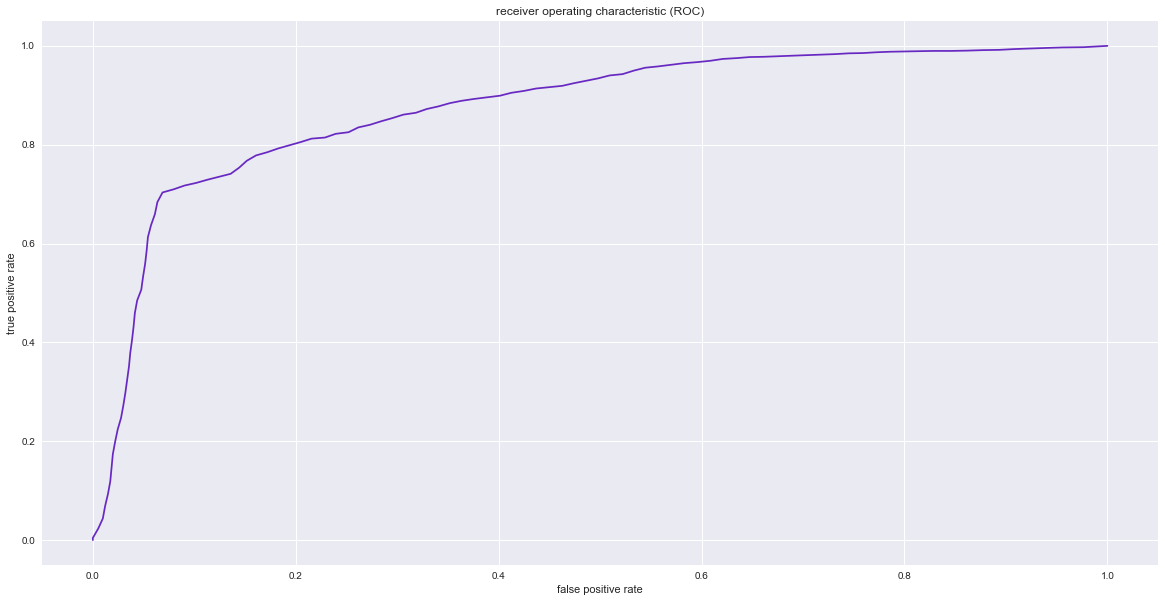

In [47]:
# Refers to the data from the last time
# we called .score(...).
fpr_g, tpr_g = pipe.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_g, tpr_g, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

## 3.5 Study Features

In [48]:
pipe.features.to_pandas()

,names,correlations,importances,target,sql
0,feature_1_1,0.651126,0.003073,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_1"";\n\nCREATE ..."
1,feature_1_2,0.676437,0.035923,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_2"";\n\nCREATE ..."
2,feature_1_3,0.659335,0.051084,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_3"";\n\nCREATE ..."
3,feature_1_4,0.456070,0.053729,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_4"";\n\nCREATE ..."
4,feature_1_5,0.648905,0.003556,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_5"";\n\nCREATE ..."
5,feature_1_6,0.284997,0.099737,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_6"";\n\nCREATE ..."
6,feature_1_7,0.446517,0.066453,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_7"";\n\nCREATE ..."
7,feature_1_8,0.660478,0.037620,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_8"";\n\nCREATE ..."
8,feature_1_9,0.640694,0.014735,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_9"";\n\nCREATE ..."
9,feature_1_10,0.646323,0.158199,occupancy,"DROP TABLE IF EXISTS ""FEATURE_1_10"";\n\nCREATE..."


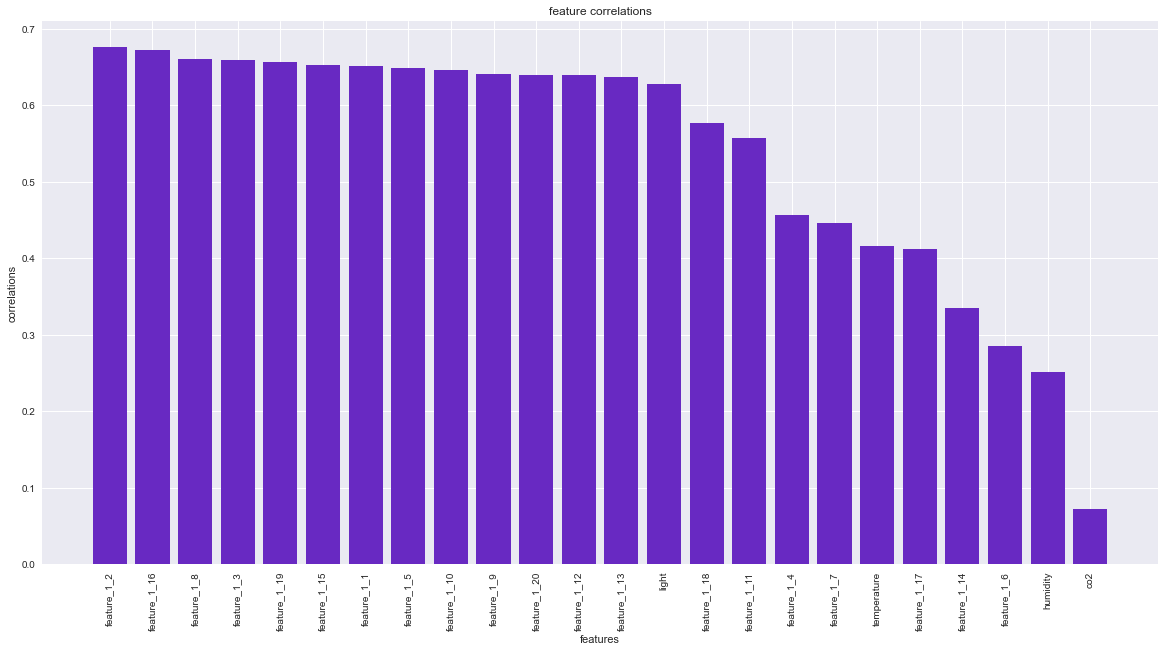

In [49]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')
plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

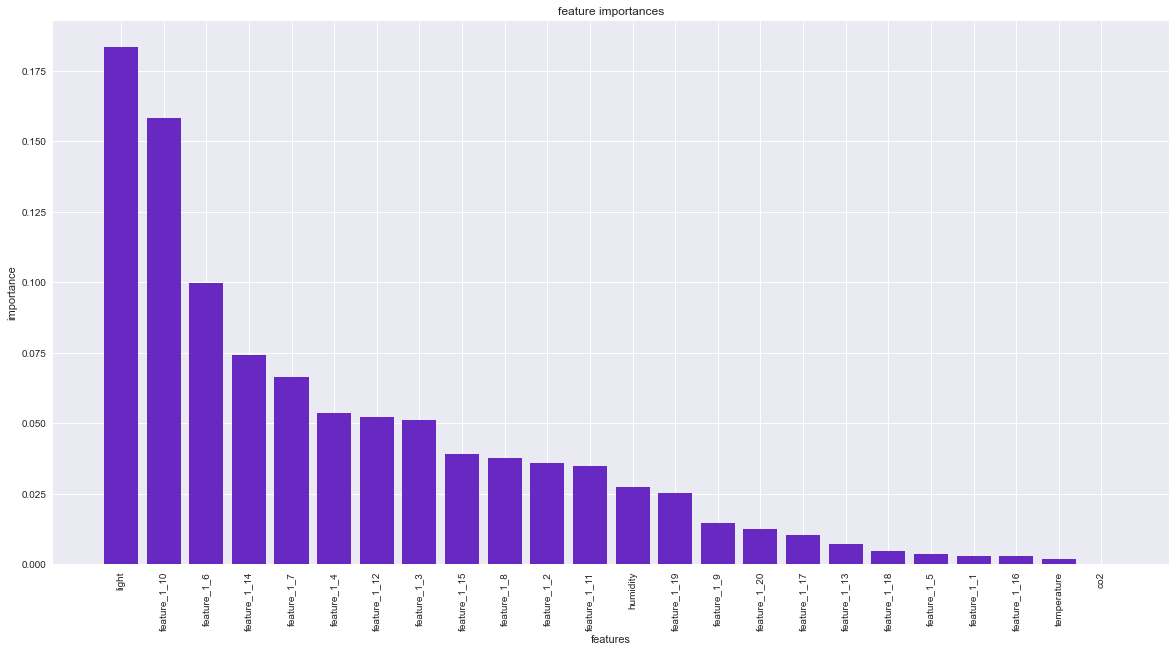

In [50]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

In [52]:
pipe.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_10";

CREATE TABLE "FEATURE_1_10" AS
SELECT SUM( t2."temperature" ) AS "feature_1_10",
       t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "POPULATION" t2
ON 1 = 1
WHERE ( julianday( t2."timestamp" ) <= julianday( t1."timestamp" )
AND ( julianday( t2."timestamp", '+1.000000 hours' ) > julianday( t1."timestamp" ) OR julianday( t2."timestamp", '+1.000000 hours' ) IS NULL )
) AND (
   ( ( t1."light" > 11.692151 ) AND ( t2."temperature" <= 24.261261 ) )
OR ( ( t1."light" <= 11.692151 OR t1."light" IS NULL  ) AND ( t2."light" > 85.830619 ) AND ( strftime('%M', t1."timestamp" ) NOT IN ( '19', '20', '00', '01', '02', '05', '09', '10', '11', '13', '16', '17', '49', '55', '57', '24', '25', '26', '28', '38', '40', '43', '31' ) ) AND ( strftime('%H', t2."timestamp" ) IN ( '18', '19', '20', '21', '23', '01', '06', '08', '09', '11', '12', '13', '14', '15', '16', '17' ) ) )
OR ( ( t1."light" <= 11.692151 OR t1."light" IS NULL  ) AND ( t2."light" > 85.830619 ) AND ( strftime('%M', t1."timestamp" ) IN ( '19', '20', '00', '01', '02', '05', '09', '10', '11', '13', '16', '17', '49', '55', '57', '24', '25', '26', '28', '38', '40', '43', '31' ) ) AND ( strftime('%H', t1."timestamp" ) IN ( '18', '20', '00', '02', '11' ) ) )
OR ( ( t1."light" <= 11.692151 OR t1."light" IS NULL  ) AND ( t2."light" <= 85.830619 OR t2."light" IS NULL  ) AND ( strftime('%M', t2."timestamp" ) NOT IN ( '19', '21', '23', '05', '06', '47', '51', '52', '53', '54', '55', '57', '58', '24', '25', '26', '27', '29', '32', '33', '38', '43', '44', '50', '31' ) ) AND ( t1."temperature" > 23.195653 ) )
OR ( ( t1."light" <= 11.692151 OR t1."light" IS NULL  ) AND ( t2."light" <= 85.830619 OR t2."light" IS NULL  ) AND ( strftime('%M', t2."timestamp" ) IN ( '19', '21', '23', '05', '06', '47', '51', '52', '53', '54', '55', '57', '58', '24', '25', '26', '27', '29', '32', '33', '38', '43', '44', '50', '31' ) ) AND ( strftime('%H', t2."timestamp" ) IN ( '18', '06', '07', '08', '09', '10', '12', '14', '15', '17' ) ) )
)
GROUP BY t1.rowid;
```

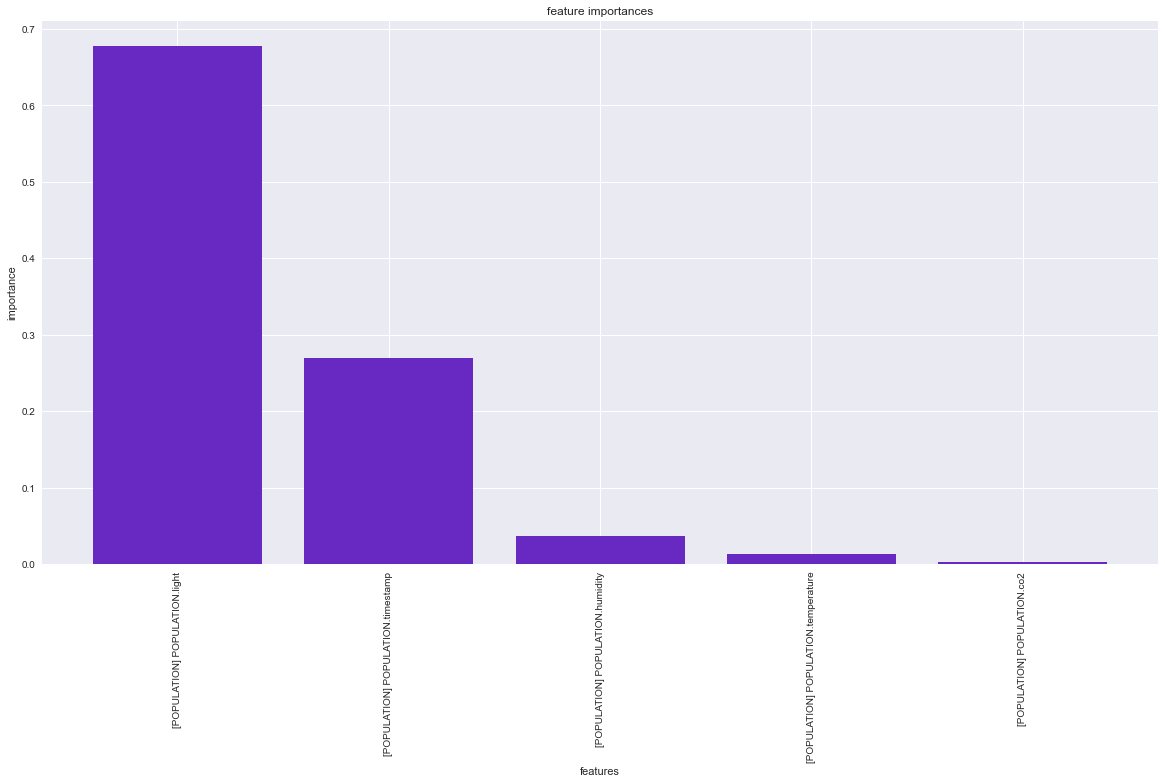

In [53]:
names, importances = pipe.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

# 4. Analysis using Featuretools

In [54]:
df_featuretools['id'] = df_featuretools.index

In [55]:
df_featuretools

,timestamp,light,humidity,temperature,co2,occupancy,id
0,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,0
1,2020-11-05 18:47:57.153393,0.000000,49.900002,22.100000,486,0,1
2,2020-11-05 18:48:58.566046,0.000000,49.900002,22.100000,484,0,2
3,2020-11-05 18:49:59.993282,0.000000,49.900002,22.100000,484,0,3
4,2020-11-05 18:51:01.430247,0.000000,49.900002,22.100000,483,0,4
...,...,...,...,...,...,...,...
19374,2020-11-19 20:05:35.017684,1.666667,51.400002,22.299999,529,0,19374
19375,2020-11-19 20:06:36.462629,1.666667,51.299999,22.200001,529,0,19375
19376,2020-11-19 20:07:45.465099,1.666667,51.500000,22.299999,520,0,19376
19377,2020-11-19 20:08:49.406900,1.666667,51.299999,22.299999,519,1,19377


Because Featuretools is a tool for automatic feature engineering on relational data, we need to bring our time series in relation with itself. Therefore we're also choosing a time window of 60 Minutes here, to create a peripheral table that can be joined with our population table.

In [56]:
peripheral = pd.DataFrame()

start = time.time()
memory_tracker.start()
for index, row in df_featuretools.iterrows():
    t = pd.to_datetime(row['timestamp'])
    until = t - pd.Timedelta(minutes=60)
    to_add = df_featuretools[(pd.to_datetime(df_featuretools['timestamp']) >= until) & (pd.to_datetime(df_featuretools['timestamp']) <= t)]
    to_add['join_key'] = int(row['id'])
    peripheral = peripheral.append(to_add)
memory_tracker.stop()
end = time.time()

print("Time elapsed: ")
print(end-start)
print("Memory consumption: ")
print(memory_tracker.peak_consumption)

<ipython-input-56-51b3ec761f1b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add['join_key'] = int(row['id'])


Time elapsed: 
583.0921814441681
Memory consumption: 
0.425623552


Wow. That was time consuming!! By taking a look at our new table, we see that we now have a table with more than a million rows. This table is mainly redundant data that just differs by their join_keys. 

In [58]:
peripheral

,timestamp,light,humidity,temperature,co2,occupancy,id,join_key
0,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,0,0
0,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,0,1
1,2020-11-05 18:47:57.153393,0.000000,49.900002,22.100000,486,0,1,1
0,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,0,2
1,2020-11-05 18:47:57.153393,0.000000,49.900002,22.100000,486,0,1,2
...,...,...,...,...,...,...,...,...
19374,2020-11-19 20:05:35.017684,1.666667,51.400002,22.299999,529,0,19374,19378
19375,2020-11-19 20:06:36.462629,1.666667,51.299999,22.200001,529,0,19375,19378
19376,2020-11-19 20:07:45.465099,1.666667,51.500000,22.299999,520,0,19376,19378
19377,2020-11-19 20:08:49.406900,1.666667,51.299999,22.299999,519,1,19377,19378


In [59]:
peripheral = peripheral.reset_index()

In [60]:
peripheral['index'] = peripheral.index
peripheral['join_key'] = peripheral['join_key'].astype(int)
peripheral['occupancy'] = peripheral['occupancy'].astype(int)
peripheral['id'] = peripheral['id'].astype(int)

In [61]:
peripheral = peripheral.drop('occupancy', axis=1)
peripheral

,index,timestamp,light,humidity,temperature,co2,id,join_key
0,0,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,0
1,1,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,1
2,2,2020-11-05 18:47:57.153393,0.000000,49.900002,22.100000,486,1,1
3,3,2020-11-05 18:46:48.192878,0.000000,50.000000,22.100000,486,0,2
4,4,2020-11-05 18:47:57.153393,0.000000,49.900002,22.100000,486,1,2
...,...,...,...,...,...,...,...,...
1121612,1121612,2020-11-19 20:05:35.017684,1.666667,51.400002,22.299999,529,19374,19378
1121613,1121613,2020-11-19 20:06:36.462629,1.666667,51.299999,22.200001,529,19375,19378
1121614,1121614,2020-11-19 20:07:45.465099,1.666667,51.500000,22.299999,520,19376,19378
1121615,1121615,2020-11-19 20:08:49.406900,1.666667,51.299999,22.299999,519,19377,19378


Now its time to feed our created tables into a featuretools workflow. Therefore we start creating the Entity Sets.

In [62]:
import featuretools as ft
es = ft.EntitySet(id="occupancy_detection")
es = es.entity_from_dataframe(entity_id="population",
                              dataframe=df_featuretools,
                              time_index="timestamp",
                              index="id")

es = es.entity_from_dataframe(entity_id="peripheral",
                             dataframe=peripheral,
                             index='index')

In [63]:
es

Entityset: occupancy_detection
  Entities:
    population [Rows: 19379, Columns: 7]
    peripheral [Rows: 1121617, Columns: 8]
  Relationships:
    No relationships

And define the relationships..

In [64]:
self_join = ft.Relationship(es["population"]["id"],
                            es["peripheral"]["join_key"])
es = es.add_relationship(self_join)

es

Entityset: occupancy_detection
  Entities:
    population [Rows: 19379, Columns: 7]
    peripheral [Rows: 1121617, Columns: 8]
  Relationships:
    peripheral.join_key -> population.id

Finally we start the *Deep Feature Synthesis* Algorithm to create our features.

In [65]:
start = time.time()
memory_tracker.start()
features, feature_names = ft.dfs(entityset=es, target_entity='population', 
                                 max_depth = 2)
memory_tracker.stop()
end = time.time()

print("Memory consumption: ")
print(memory_tracker.peak_consumption)

print("elapsed time: ")
print(end-start)

features = features.dropna()
features

Memory consumption: 
0.16171008
elapsed time: 
32.12456011772156


,light,humidity,temperature,co2,occupancy,COUNT(peripheral),MAX(peripheral.co2),MAX(peripheral.humidity),MAX(peripheral.id),MAX(peripheral.light),...,WEEKDAY(timestamp),YEAR(timestamp),MODE(peripheral.DAY(timestamp)),MODE(peripheral.MONTH(timestamp)),MODE(peripheral.WEEKDAY(timestamp)),MODE(peripheral.YEAR(timestamp)),NUM_UNIQUE(peripheral.DAY(timestamp)),NUM_UNIQUE(peripheral.MONTH(timestamp)),NUM_UNIQUE(peripheral.WEEKDAY(timestamp)),NUM_UNIQUE(peripheral.YEAR(timestamp))
id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,49.900002,22.100000,484,0,3,486,50.000000,2,0.000000,...,3,2020,5,11,3,2020,1,1,1,1
3,0.000000,49.900002,22.100000,484,0,4,486,50.000000,3,0.000000,...,3,2020,5,11,3,2020,1,1,1,1
4,0.000000,49.900002,22.100000,483,0,5,486,50.000000,4,0.000000,...,3,2020,5,11,3,2020,1,1,1,1
5,0.000000,50.000000,22.100000,484,0,6,486,50.000000,5,0.000000,...,3,2020,5,11,3,2020,1,1,1,1
6,0.000000,50.000000,22.100000,485,0,7,486,50.000000,6,0.000000,...,3,2020,5,11,3,2020,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19374,1.666667,51.400002,22.299999,529,0,58,533,52.200001,19374,85.833333,...,3,2020,19,11,3,2020,1,1,1,1
19375,1.666667,51.299999,22.200001,529,0,58,533,52.200001,19375,85.833333,...,3,2020,19,11,3,2020,1,1,1,1
19376,1.666667,51.500000,22.299999,520,0,58,533,52.200001,19376,85.833333,...,3,2020,19,11,3,2020,1,1,1,1


Also Featuretools doesn't come with a predictor. Therefore we're using getml for predictive modelling. Let's start by setting up a new project in the getml engine.

In [66]:
import getml

getml.engine.set_project('occupancy_featuretools_kitchen')

Loading existing project 'occupancy_featuretools_kitchen'


And then split our Data into a train a test set with a 70:30 ratio.

In [67]:
#feature_matrix['occupancy'].replace({'f':0,'t':1}, inplace=True)
train = features[:int(len(features)*0.7)]
test = features[int(len(features)*0.7):]

Now we're importing our pandas dataframes into the getml engine. They will be transformed into getml dataframes and for feature learning and modelling we need to assign the fitting rules to our variables. 

In [70]:
featuretools_train = getml.data.DataFrame.from_pandas(train, "featuretools_train")
featuretools_test = getml.data.DataFrame.from_pandas(test, "featuretools_test")

In [71]:
for df in [featuretools_train, featuretools_test]:
    df.set_role("occupancy", getml.data.roles.target)
    df.set_role(df.unused_float_names, getml.data.roles.numerical)

The next step is creating a getML Pipeline. 

As a predictor we're choosing a simple Logistic Regression.

From experience we know, that many of the features that are created by featuretools with a minimum of user afford, are not relevant for our predictions. Therefore we're assigning a second Logistic Regression as a feature selector in our pipeline. This will instruct the workflow to select a share of the most relevant features after the first model training. 

In [72]:
predictor = getml.predictors.LogisticRegression()
selector = getml.predictors.LogisticRegression()
#seasonal = getml.preprocessors.Seasonal()

pipe_featuretools = getml.pipeline.Pipeline(
    tags=['featuretools'],
    predictors=[predictor],
    feature_selectors=selector,
    share_selected_features=0.5,
    #preprocessors=[seasonal]
)

In [73]:
pipe_featuretools.fit(featuretools_train)

WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'SKEW(peripheral.id)' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'MONTH(timestamp)' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'YEAR(timestamp)' in  data frame 'POPULATION' are equal to each other. You should consider setting its role to unused_float or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
WARNING [COLUMN SHOULD BE UNUSED]: All non-NULL entries in column 'MODE(peripheral.MONTH(timestamp))' in

Checking data model...

LogisticRegression: Training as feature selector...
[========================================] 100%

LogisticRegression: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:0.519892



Pipeline(preprocessors=[], feature_learners=[], 
         feature_selectors=['LogisticRegression'], include_categorical=False, 
         peripheral=[], population='POPULATION', 
         predictors=['LogisticRegression'], tags=['featuretools'], 
         share_selected_features=0.5)

url: http://localhost:1709/getpipeline/Jf9tzr/0/

In [74]:
in_sample = pipe_featuretools.score(featuretools_train)

out_of_sample = pipe_featuretools.score(featuretools_test)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)




Accuracy (training): 0.84922
AUC (training): 0.87668

Accuracy (testing): 0.84744
AUC (testing): 0.88507



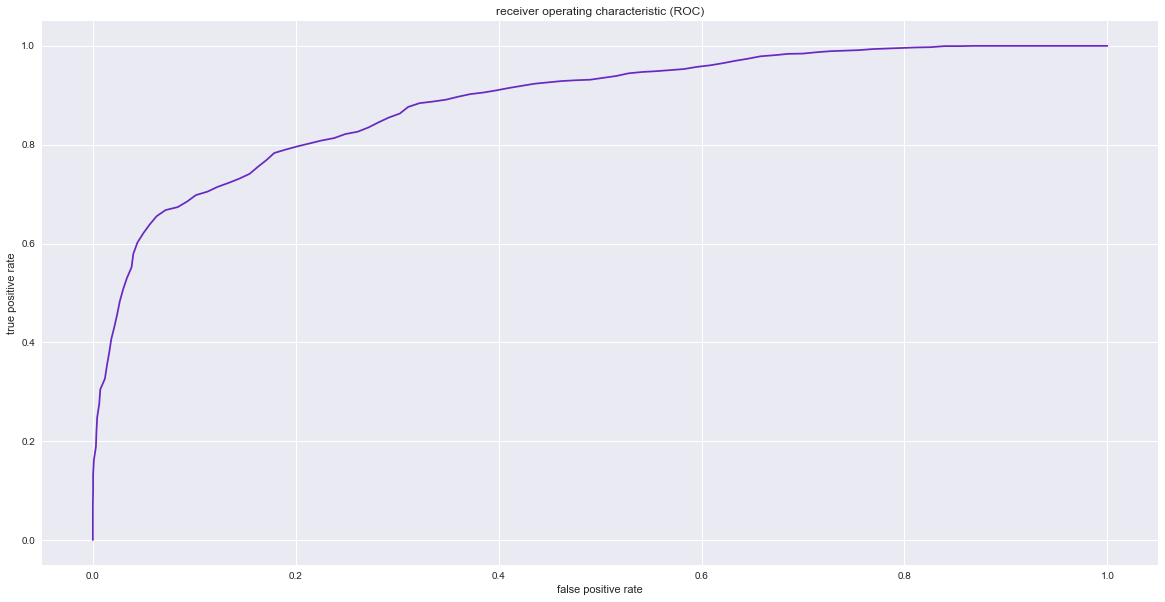

In [80]:
## Refers to the data from the last time
# we called .score(...).
fpr_ft, tpr_ft = pipe_featuretools.metrics.roc_curve()

plt.subplots(figsize=(20, 10))

plt.plot(fpr_ft, tpr_ft, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

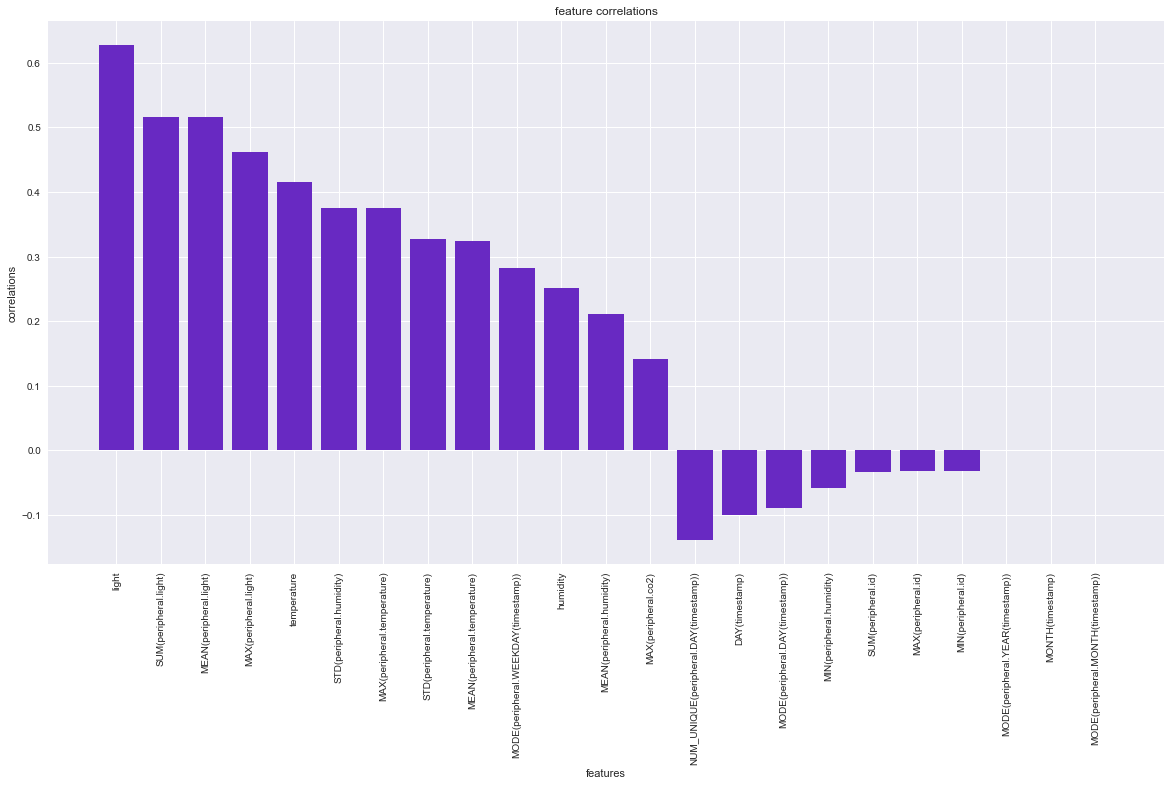

In [81]:
names, correlations = pipe_featuretools.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

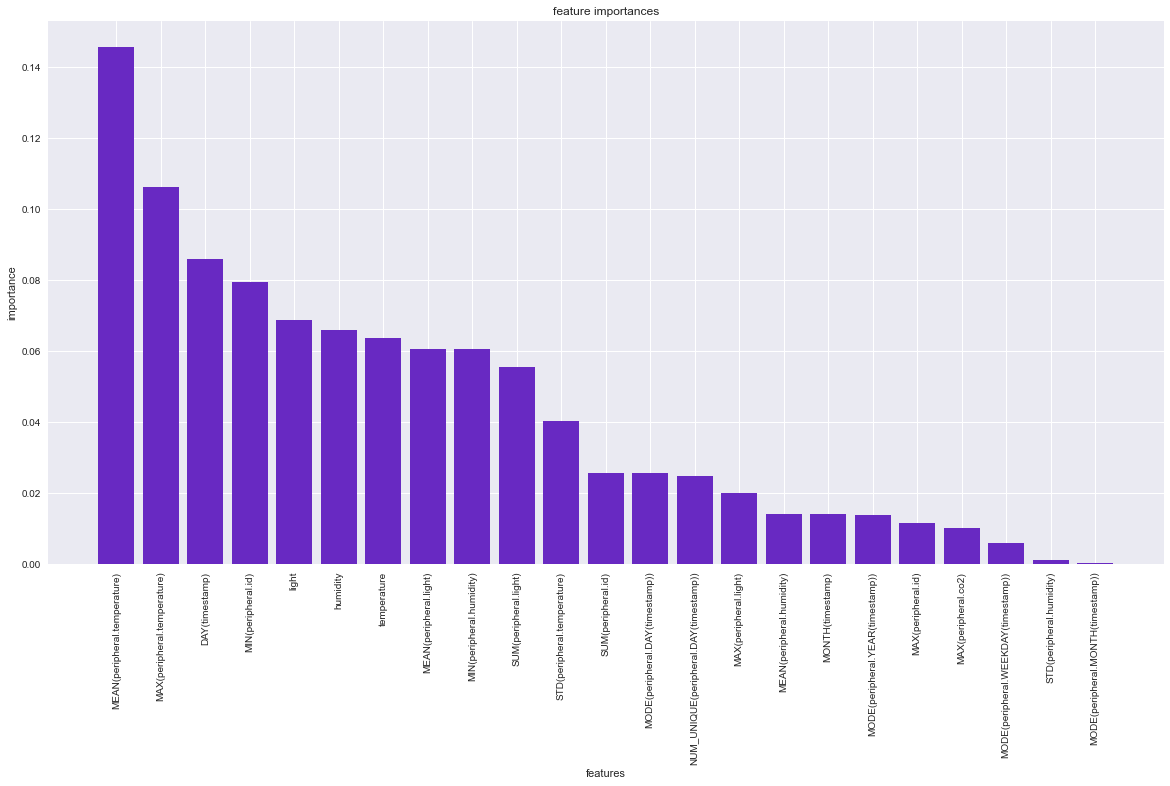

In [82]:
names, importances = pipe_featuretools.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

# 5. Summarizing the Results

First lets get the True Postive and False Postive Rates from our best model with respect to AUC created with manual feature engineering. 

In [83]:
fpr_man, tpr_man, _ = sorted_by_auc[0]['roc_test']

And then use a ROC Curve for every model to get an overview of their predictive powers.

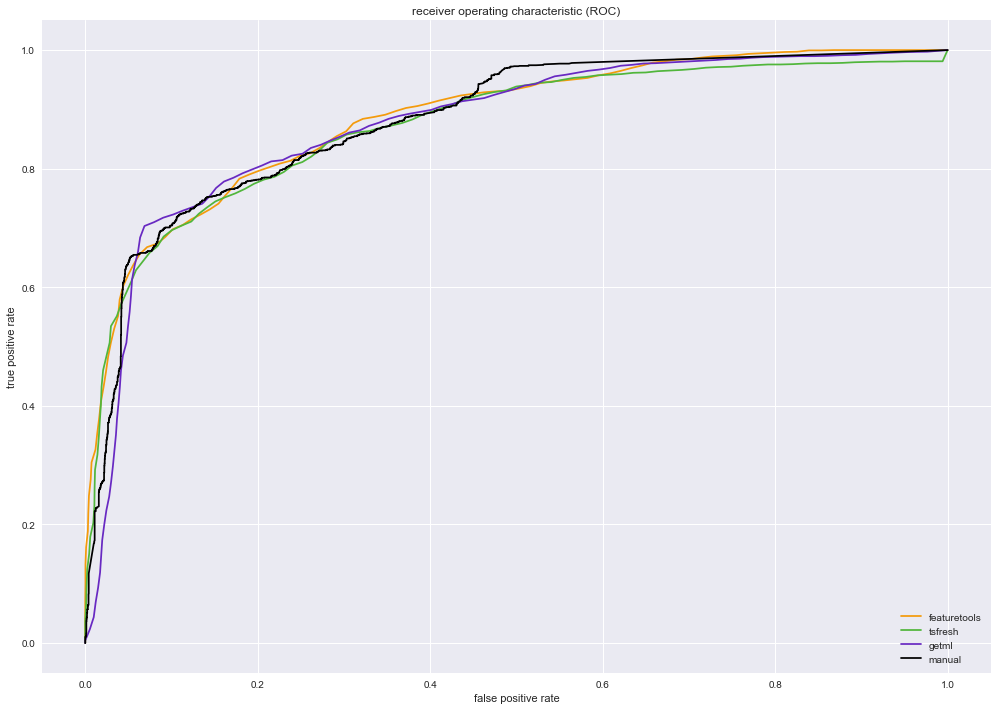

In [77]:
plt.subplots(figsize=(17, 12))

plt.plot(fpr_ft, tpr_ft, color='#f49b0c', label="featuretools")
plt.plot(fpr_ts, tpr_ts, color='#51b63c', label="tsfresh")
plt.plot(fpr_g, tpr_g, color='#6829c2', label="getml")
plt.plot(fpr_man, tpr_man, color='black', label="manual")


plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc='lower right')
plt.show()